# Ý tưởng:
* Tính độ tương đồng giữa các item dựa trên tập dữ liệu về item
* Gợi ý k item tương tự với item và user đã sử dụng gần đây nhất
* Nếu gần đây user không sử dụng item nào thì gợi ý k item phổ biến nhất

In [ ]:
from google.colab import drive
drive.mount('/content/gdrvie')

Mounted at /content/gdrvie


In [ ]:
%cd gdrvie/MyDrive/CMC-CIST/DataPack_Recommendation
!ls

/content/gdrvie/MyDrive/CMC-CIST/DataPack_Recommendation
Content_Based_RS.ipynb	Data  similar_item_rs.ipynb


In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

## Danh sách gói cước

In [ ]:
df_item = pd.read_excel('Data/list_goi_cuoc.xlsx')
df_item = df_item.set_index('ten_goi')
df_item.head()

,loai_goi,Gia (1000đ),thoi_luong (ngày),luu_luong_thoai_noi_mang (phút),luu_luong_thoai_ngoai_mang (phút),luu_luong_sms (số sms),luu_luong_data (Gb),duong_truyen (mbs),note
ten_goi,,,,,,,,,
KM_VNP100,VNP,100,30,NaN,NaN,NaN,4,NaN,NaN
KM_VNP120,VNP,120,30,NaN,NaN,NaN,6,NaN,NaN
KM_VNP250MB,VNP,250,30,NaN,NaN,NaN,12,NaN,NaN
KM_VNP50MB,VNP,50,30,NaN,NaN,NaN,1.5,NaN,NaN
MED_DH1,MED,0,30,NaN,NaN,NaN,NaN,NaN,gói cước ứng dịch vụ


In [ ]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, KM_VNP100 to MI_H10
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loai_goi                            545 non-null    object 
 1   Gia (1000đ)                         575 non-null    object 
 2   thoi_luong (ngày)                  576 non-null    object 
 3   luu_luong_thoai_noi_mang (phút)    200 non-null    object 
 4   luu_luong_thoai_ngoai_mang (phút)  101 non-null    float64
 5   luu_luong_sms (số sms)             59 non-null     float64
 6   luu_luong_data (Gb)                 448 non-null    object 
 7   duong_truyen (mbs)                  27 non-null     float64
 8   note                                83 non-null     object 
dtypes: float64(3), object(6)
memory usage: 45.0+ KB


## Lịch sử người dùng

In [ ]:
df_user_history = pd.read_csv('Data/user_historical_data.csv', usecols=['so_tb', 'period', 'goi_dky'])
print('Number of records:', len(df_user_history))
df_user_history.head(10)

Number of records: 99060


,so_tb,period,goi_dky
0,185,2020-07-01,['EZ_D500']
1,185,2020-08-01,['EZ_D500']
2,185,2020-09-01,['EZ_D500']
3,185,2020-10-01,['EZ_D500']
4,185,2020-11-01,['EZ_D500']
5,185,2020-12-01,['EZ_D500']
6,185,2021-01-01,[]
7,185,2021-02-01,[]
8,255,2021-01-01,[]
9,255,2021-02-01,[]


In [ ]:
# Thống kê các item được user sử dụng trong bộ dữ liệu lịch sử người dùng
list_item = {}
for val in df_user_history['goi_dky']:
  val = val[1:-1]
  if val !='':
    for item in val.split(','):
      item = item.strip()[1:-1]
      if item not in list(list_item.keys()):
        list_item[item] = 0
      else:
        list_item[item] = list_item[item] + 1 

In [ ]:
popular_item = [x[0] for x in sorted(list_item.items(), key=lambda item: item[1], reverse=True)]
popular_item

['MI_D2',
 'MI_D7',
 'MI_D5',
 'V10',
 'VD2',
 'C50',
 'MI_BIGFORMOSA_2GBN',
 'KM_D3',
 'B30',
 'VD89',
 'C15',
 'KM_ADDONGAME_50MB',
 'VMAX',
 'KM_ADDONGAME_100MB',
 'C69',
 'KM_ADDONGAME_250MB',
 'GD0',
 'TN20',
 'EZ_D500_0KKH',
 'MI_ZONE_THAGA',
 'GDS',
 'MI_BIGKM_4GBN',
 'MI_MAX70N',
 'MI_D15',
 'KM_DT30',
 'V10MP',
 'MI_BIGKM_2GB15N',
 'MI_MAXS',
 'MI_D500',
 'EZ_DMAX_4G5',
 'MI_MAX100_TGDD_NEW',
 'DC_HOME1',
 'MI_D5K',
 'VD10',
 'VD89P',
 'KM_ADDONGAME_500MB',
 'VD149',
 'KM_DATAM_1G',
 'KM_DATA4G_4G',
 'MI_BIG_60G_2GBN',
 'MI_BIG90',
 'MI_MAXINKM1',
 'MI_BUM360',
 'C89',
 'MI_MAX2G5_TGDD',
 'B99',
 'MI_ZONE_12THAGA',
 'MI_BIGKM_2GB7N',
 'MI_BIG70',
 'MI_MAX100N',
 'V10K',
 'KM_DATAM_1G5',
 'MI_M10',
 'MI_D60G',
 'KMM_BIG_1GB',
 'MI_BUMDATA',
 'GD3',
 'EZ_D500',
 'MI_MECLIP',
 'MI_FPT_PLAY',
 'MED_V4',
 'MED_V3',
 'MI_BIGKM_1GBN',
 'MI_D3K',
 'MI_VD40K',
 'MI_VTVCAB',
 'MI_BUM35',
 'CAPDOI',
 'MI_SCTV_PHIM',
 'MI_MAX_3GB_9M',
 'KM_DATAM_500MB',
 'MI_MAXKMCB_300M',
 'MI_BIGFD_2GBN

In [ ]:
def item_registered(x):
  x = x[1:-1]
  if x =='':
    return '0'
  return x.split(',')[0][1:-1]

In [ ]:
# Các item mà user sử dụng gần đây nhất
df_user = df_user_history.drop_duplicates(subset=['so_tb'], keep='last')
df_user['goi_dky_v1'] = df_user['goi_dky'].apply(item_registered)
print('Number of user:',len(df_user))
df_user.head()

Number of user: 4949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,so_tb,period,goi_dky,goi_dky_v1
7,185,2021-02-01,[],0
9,255,2021-02-01,[],0
27,382,2021-02-01,['DC_HOME1'],DC_HOME1
39,403,2021-02-01,[],0
64,454,2021-02-01,"['MI_D7', 'MI_D7', 'MI_D7', 'MI_D7', 'MI_D7', ...",MI_D7


# Preprocessing

## Dữ liệu bị null

### Gói cước bị null

In [ ]:
df_item_null = df_item.isnull().sum(axis =1)*100/df_item.shape[1]
print(df_item_null)
for i in range(0, 11):
  print("Số gói cước bị null hơn "+str(i*10)+"% là:", len(df_item_null[df_item_null > i*10]))

ten_goi
KM_VNP100               55.555556
KM_VNP120               55.555556
KM_VNP250MB             55.555556
KM_VNP50MB              55.555556
MED_DH1                 55.555556
MED_S3                  55.555556
MI_VIX15                55.555556
MI_VIX25                55.555556
MI_VIX35                55.555556
MI_X10                  55.555556
MI_X19                  55.555556
MI_X25_OCS              55.555556
MI_X29                  55.555556
MI_X290                 55.555556
MI_X49                  55.555556
MI_X5                   55.555556
MI_X15                  55.555556
MI_X25                  55.555556
MI_X35                  55.555556
FS_X25                  55.555556
KM_VNP100MB             55.555556
KM_VNP150               55.555556
KM_VNP50                55.555556
MI_FX18                 55.555556
MI_X100                 55.555556
MI_X190                 55.555556
MI_X39                  55.555556
MI_XVNP20               55.555556
VN50                    55.555556
DC_FIM

### Feature của gói cước bị null

In [ ]:
df_item.isnull().sum()*100/df_item.shape[0]

loai_goi                               5.381944
Gia (1000đ)                            0.173611
thoi_luong (ngày)                     0.000000
luu_luong_thoai_noi_mang (phút)      65.277778
luu_luong_thoai_ngoai_mang (phút)    82.465278
luu_luong_sms (số sms)               89.756944
luu_luong_data (Gb)                   22.222222
duong_truyen (mbs)                    95.312500
note                                  85.590278
dtype: float64

## Xử lý các feature null
* Xử lý các feaute: 
> * Loại gói
> * Giá (1000 đ)
> * Thời lượng (ngày)
> * Lưu lượng thoại nội mạng (phút)
> * Lưu lượng thoại ngoại mạng (phút)
> * Lưu lượng sms (số sms)
> * Lưu lượng data (GB)
* Bỏ feature:
> * Đường truyền (mbs)
> * Note

In [ ]:
def visualize(feature_category, title):
  values = df_item[feature_category].value_counts().values
  labels = df_item[feature_category].value_counts().index
  index = np.arange(len(values))
  plt.figure(figsize=(15,5))
  plt.xticks(index, labels, rotation=90)
  plt.title(title, fontsize=15, fontweight='bold')
  plt.bar(index, values)
  for x, y in zip(index, values):
    plt.text(x, y, str(y))
  plt.show()
  print('Number of values:', len(values))
  print('Number of null records:', df_item[feature_category].isnull().sum())
  
def rescaling(df):
  min = np.min(df)
  max = np.max(df)
  for i in range(len(df)):
    df[i] = (df[i] - min)/(max-min)
  return df

### Xóa các feature: 

### loai_goi
Đang có 5.38% bản ghi bị null -> Những loại gói bị null điền thông tin là 'UNK'

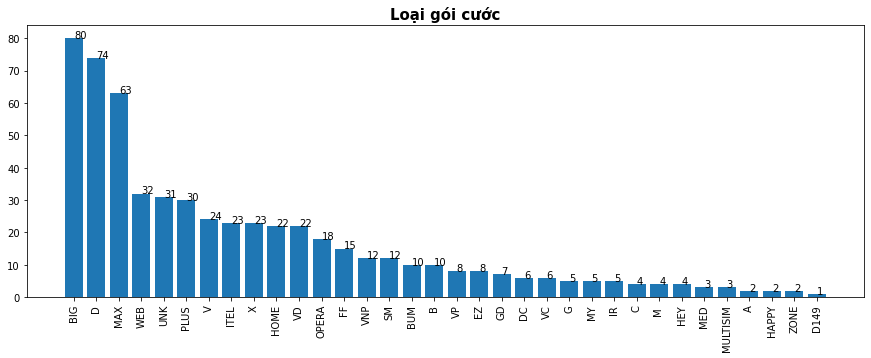

Number of values: 34
Number of null records: 0


In [ ]:
df_item['loai_goi'].fillna('UNK', inplace=True)
visualize('loai_goi', 'Loại gói cước') 

### Gia (1000đ)

In [ ]:
# Điền giá trị còn thiếu = 0 (0 là các gói khuyến mại)
df_item['Gia (1000đ)'] = df_item['Gia (1000đ)'].fillna(0)

In [ ]:
# Chuyển từ object về numerical
df_item['Gia (1000đ)'] = pd.to_numeric(df_item['Gia (1000đ)'], errors = 'coerce')

In [ ]:
# Rescaling
df_item['Gia (1000đ)'] = rescaling(df_item['Gia (1000đ)'])

# Static
df_item['Gia (1000đ)'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    575.000000
mean       0.090521
std        0.136013
min        0.000000
25%        0.011830
50%        0.039432
75%        0.094637
max        1.000000
Name: Gia (1000đ), dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Number null records: 0


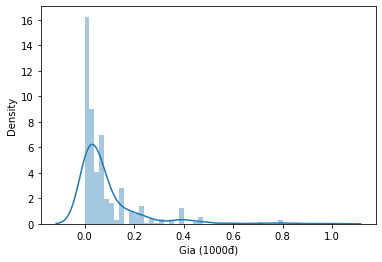

In [ ]:
sns.distplot(df_item['Gia (1000đ)'])
print('Number null records:', df_item['Gia (1000đ)'].isnull().sum())

### thoi_luong (ngày)
Chia làm 8 gói cước:
> * trong ngày: thời lượng dùng <= 1 ngày
> * nhỏ hơn 30 ngày: thời lượng dùng < 30 ngày
> * trong tháng : thời lượng = 30 ngày
> * 90
> * 180
> * 360
> * Có hạn
> * Không thời hạn

In [ ]:
def processing_time(x):
  x = str(x)
  if x == "không thời hạn" or x =="không giới hạn":
    x = 'không thời hạn'
  elif x =="có hạn":
    x = 'có hạn'
  else:
    x = float(x)
    if x <= 1:
      x = 'trong ngày'
    elif x < 30:
      x = 'nhỏ hơn 30 ngày'
  return str(x)

df_item['thoi_luong (ngày)'] = df_item['thoi_luong (ngày)'].apply(processing_time)

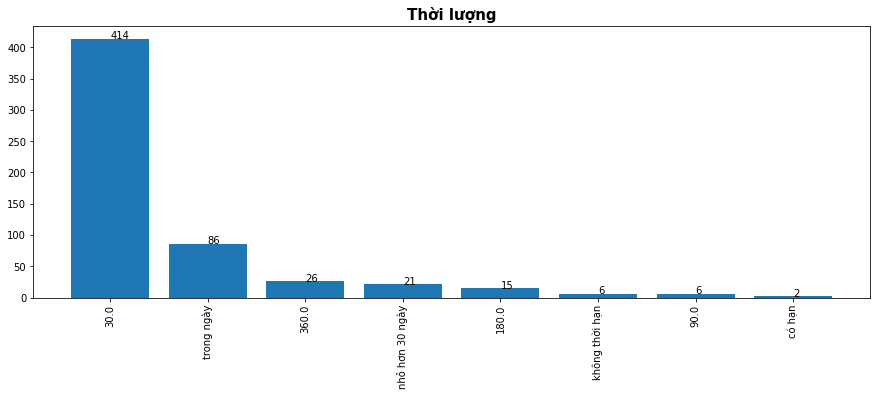

Number of values: 8
Number of null records: 0


In [ ]:
visualize('thoi_luong (ngày)', 'Thời lượng')

### luu_luong_thoai_noi_mang (phút)

In [ ]:
# Fill nan = 0
df_item['luu_luong_thoai_noi_mang (phút)'].fillna(0, inplace=True)

# Hàm tiền xử lý 
def process_one_net(x):
  x = str(x)
  if x == 'giảm 50%':
    return 0
  if x[0] == '<':
    return float(x[1:]) - 1/60
  return float(x)

df_item['luu_luong_thoai_noi_mang (phút)'] = df_item['luu_luong_thoai_noi_mang (phút)'].apply(process_one_net) 

# Rescaling
df_item['luu_luong_thoai_noi_mang (phút)'] = rescaling(df_item['luu_luong_thoai_noi_mang (phút)'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_item['luu_luong_thoai_noi_mang (phút)'].describe()

count    576.000000
mean       0.018143
std        0.070022
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000832
max        1.000000
Name: luu_luong_thoai_noi_mang (phút), dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


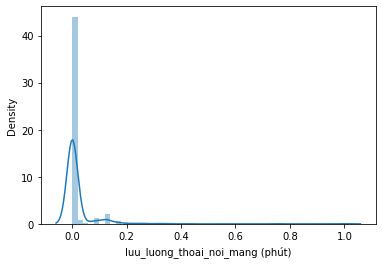

In [ ]:
sns.distplot(df_item['luu_luong_thoai_noi_mang (phút)'])

luu_luong_thoai_ngoai_mang (phút)

In [ ]:
# Fill nan = 0
df_item['luu_luong_thoai_ngoai_mang (phút)'].fillna(0, inplace=True)

# Rescaling
df_item['luu_luong_thoai_ngoai_mang (phút)'] = rescaling(df_item['luu_luong_thoai_ngoai_mang (phút)'])

# Static
df_item['luu_luong_thoai_ngoai_mang (phút)'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    576.000000
mean       0.016486
std        0.075031
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: luu_luong_thoai_ngoai_mang (phút), dtype: float64

### luu_luong_sms (số sms)

In [ ]:
# Fill nan = 0
df_item['luu_luong_sms (số sms)'].fillna(0, inplace=True)

# Rescaling
df_item['luu_luong_sms (số sms)'] = rescaling(df_item['luu_luong_sms (số sms)'])

# Static
df_item['luu_luong_sms (số sms)'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    576.000000
mean       0.013747
std        0.063732
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: luu_luong_sms (số sms), dtype: float64

### luu_luong_data (Gb)  
* Tiền xử lý:
> * lưu lượng data == null => 0 (GB)
> * 60GB -> 60 hoặc 30 mbs -> 0
* Rescaling

In [ ]:
# Fill nan
df_item['luu_luong_data (Gb)'].fillna(0, inplace=True)

# Preprocessing
def processing_data_usage(x):
  x = str(x).lower()
  if x[-2:] == 'gb':
    x = float(x[:-2])
  elif x[-3:] == 'mbs':
    x = 0
  return float(x)
df_item['luu_luong_data (Gb)'] = df_item['luu_luong_data (Gb)'].apply(processing_data_usage)

# Rescaling
df_item['luu_luong_data (Gb)'] = rescaling(df_item['luu_luong_data (Gb)'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_item['luu_luong_data (Gb)'].describe()

count    576.000000
mean       0.020196
std        0.066744
min        0.000000
25%        0.000167
50%        0.001833
75%        0.012500
max        1.000000
Name: luu_luong_data (Gb), dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


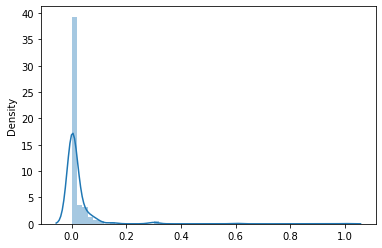

In [ ]:
sns.distplot(df_item['luu_luong_data (Gb)'].values)

In [ ]:
# Giữ lại các feature đã xử lý null
df_item_new = df_item.drop(['duong_truyen (mbs)', 'note'], axis=1)
df_item_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, KM_VNP100 to MI_H10
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loai_goi                            576 non-null    object 
 1   Gia (1000đ)                         576 non-null    float64
 2   thoi_luong (ngày)                  576 non-null    object 
 3   luu_luong_thoai_noi_mang (phút)    576 non-null    float64
 4   luu_luong_thoai_ngoai_mang (phút)  576 non-null    float64
 5   luu_luong_sms (số sms)             576 non-null    float64
 6   luu_luong_data (Gb)                 576 non-null    float64
dtypes: float64(5), object(2)
memory usage: 56.0+ KB


## One hot encoding

In [ ]:
def one_hot_encoder(df_item_new, feature_name):
  df_encoder = pd.get_dummies(df_item_new[feature_name], prefix=feature_name)
  df_item_new = pd.concat([df_item_new, df_encoder], axis= 1)
  df_item_new.drop([feature_name], axis=1, inplace=True)
  return df_item_new

In [ ]:
categorical_feature = df_item_new.select_dtypes(include=['object']).columns
for feature_name in categorical_feature:
  df_item_new = one_hot_encoder(df_item_new, feature_name)

In [ ]:
df_item_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, KM_VNP100 to MI_H10
Data columns (total 47 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Gia (1000đ)                         576 non-null    float64
 1   luu_luong_thoai_noi_mang (phút)    576 non-null    float64
 2   luu_luong_thoai_ngoai_mang (phút)  576 non-null    float64
 3   luu_luong_sms (số sms)             576 non-null    float64
 4   luu_luong_data (Gb)                 576 non-null    float64
 5   loai_goi_A                          576 non-null    uint8  
 6   loai_goi_B                          576 non-null    uint8  
 7   loai_goi_BIG                        576 non-null    uint8  
 8   loai_goi_BUM                        576 non-null    uint8  
 9   loai_goi_C                          576 non-null    uint8  
 10  loai_goi_D                          576 non-null    uint8  
 11  loai_goi_D149                       576

# Recommendation Pack Data

## Similarity

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_matrix = cosine_similarity(df_item_new)

In [ ]:
cosine_matrix

array([[1.00000000e+00, 9.99937583e-01, 9.96562234e-01, ...,
        9.73087139e-05, 1.58020755e-04, 3.17423375e-04],
       [9.99937583e-01, 1.00000000e+00, 9.97424555e-01, ...,
        1.17937693e-04, 1.90326518e-04, 3.82725839e-04],
       [9.96562234e-01, 9.97424555e-01, 1.00000000e+00, ...,
        2.43373978e-04, 3.93242734e-04, 7.90600001e-04],
       ...,
       [9.73087139e-05, 1.17937693e-04, 2.43373978e-04, ...,
        1.00000000e+00, 9.99999204e-01, 9.99991687e-01],
       [1.58020755e-04, 1.90326518e-04, 3.93242734e-04, ...,
        9.99999204e-01, 1.00000000e+00, 9.99994551e-01],
       [3.17423375e-04, 3.82725839e-04, 7.90600001e-04, ...,
        9.99991687e-01, 9.99994551e-01, 1.00000000e+00]])

## Recommend similarity data pack

In [ ]:
indices = pd.Series(data=np.arange(len(df_item_new.index.values)), index= df_item_new.index.values)
df_pack_data = pd.DataFrame({'item': df_item.index.values})

def get_recommendations(pack_data, k = 10, cosine_sim= cosine_matrix):
  """
  pack_data  : tên gói cước
  k          : top k gói cước cần recommend (tính cả gói cước đang dùng)
  cosine_sim : ma trận tương đồng (similar matrix)
  """
  # Get the index of the data pack
  idx = indices[pack_data]

  # Get the pairwise similarity scores of all data pack
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Sort the data pack based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get the scores of the k most similar data pack
  sim_scores = sim_scores[0:k]

  # Get the data pack indices
  pack_data_indices = [i[0] for i in sim_scores]

  # Return the top k most similar data pack
  return df_pack_data['item'].iloc[pack_data_indices]

In [ ]:
# Giợi ý các gói cước tương đồng
data_pack = 'MI_BIGFORMOSA_2GBN'
get_recommendations(pack_data=data_pack, k=5)

240     MI_BIGFORMOSA_2GBN
211    MI_BIG_50K_60G_2GBN
213        MI_BIG_60G_2GBN
207          MB_BIGCD_30GB
233          MI_BIGCD_30GB
Name: item, dtype: object

## Recommendation for user

In [ ]:
def recommend_4_user(user_id, k=10):
  user = df_user.loc[df_user['so_tb'] == user_id]
  if len(user) == 0:
    print('Không tồn tại user {} trong dữ liệu'.format(user_id))
    return
  item = user['goi_dky_v1'].values[0]
  if item in list(df_item.index.values):
    items = list(get_recommendations(pack_data).values)
  else:
    items = popular_item[:k]
  for idx, i in enumerate(items):
    print('Recommendation {}: {}'.format(idx + 1, i))

In [ ]:
recommend_4_user(454)

Recommendation 1: MI_BIGFORMOSA_2GBN
Recommendation 2: MI_BIG_50K_60G_2GBN
Recommendation 3: MI_BIG_60G_2GBN
Recommendation 4: MB_BIGCD_30GB
Recommendation 5: MI_BIGCD_30GB
Recommendation 6: MI_BIGKM_1GB23N
Recommendation 7: MI_BIGHS_2GB
Recommendation 8: MI_BIG_4GBN
Recommendation 9: MI_BIG_5GBN
Recommendation 10: MI_BIG70
